# Identifying the Minimum Threshold for XGBoost Performance

The goal of this notebook is to identify the minimum number of observations necessary for XGBoost to make predictions accurately.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv', index_col=[0], parse_dates=[0])

### Create Features

In [3]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['PJME_MW'].shift(i+1)

    return df

In [4]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

### Define Scoring Function

In [5]:
import math

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Nested Cross-Validation

https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

K-Fold Cross Validation is the gold standard for validating ML algorithms. However, K-Fold Cross Validation does not work with time-series, as it fails to capture temporal dependencies. Instead, we'll use nested cross validation. Nested cross-validation resembles backtesting. The dataset is split up into several training sets and testing sets, with each training set using the subsequent year as a testing set. This way, cross-validation is performed in a step-wise manner, using each time period except the first as a testing set to validate training performed on any prior time period.

In [6]:
start_dates = [
    '01-JAN-2002',
    '01-JAN-2003',
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011', 
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015'
]

split_dates = [
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016', 
    '01-JAN-2017' 
]

end_dates = [
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016',
    '01-JAN-2017', 
    '01-JAN-2018' 
]

#### 2-years Nested Cross-Validation

We know that XGBoost works with 5 years of data, so to push our limits of N, we will try with predicting a year's worth of data with only two years worth of training. The below code iterates the list of starting dates, learning on the five-year period following that start date. The model then uses the sixth year as a testing set.

start date:  01-JAN-2002
split date:  01-JAN-2004
end date:  01-JAN-2005 

start date:  01-JAN-2003
split date:  01-JAN-2005
end date:  01-JAN-2006 

start date:  01-JAN-2004
split date:  01-JAN-2006
end date:  01-JAN-2007 

start date:  01-JAN-2005
split date:  01-JAN-2007
end date:  01-JAN-2008 

start date:  01-JAN-2006
split date:  01-JAN-2008
end date:  01-JAN-2009 

start date:  01-JAN-2007
split date:  01-JAN-2009
end date:  01-JAN-2010 

start date:  01-JAN-2008
split date:  01-JAN-2010
end date:  01-JAN-2011 

start date:  01-JAN-2009
split date:  01-JAN-2011
end date:  01-JAN-2012 

start date:  01-JAN-2010
split date:  01-JAN-2012
end date:  01-JAN-2013 

start date:  01-JAN-2011
split date:  01-JAN-2013
end date:  01-JAN-2014 

start date:  01-JAN-2012
split date:  01-JAN-2014
end date:  01-JAN-2015 

start date:  01-JAN-2013
split date:  01-JAN-2015
end date:  01-JAN-2016 

start date:  01-JAN-2014
split date:  01-JAN-2016
end date:  01-JAN-2017 

start date:  01-JAN-2015


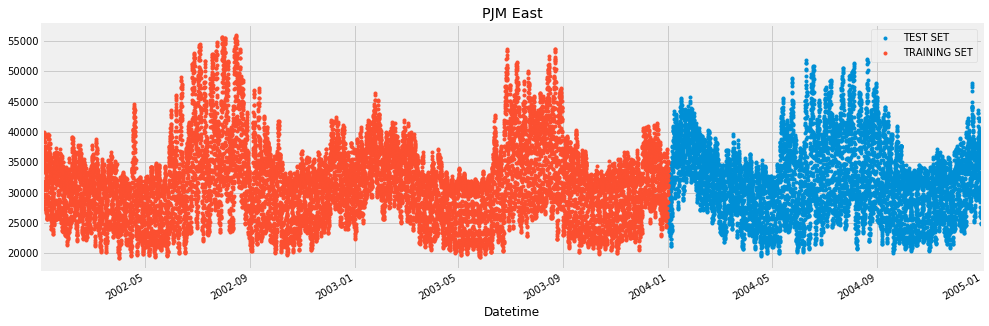

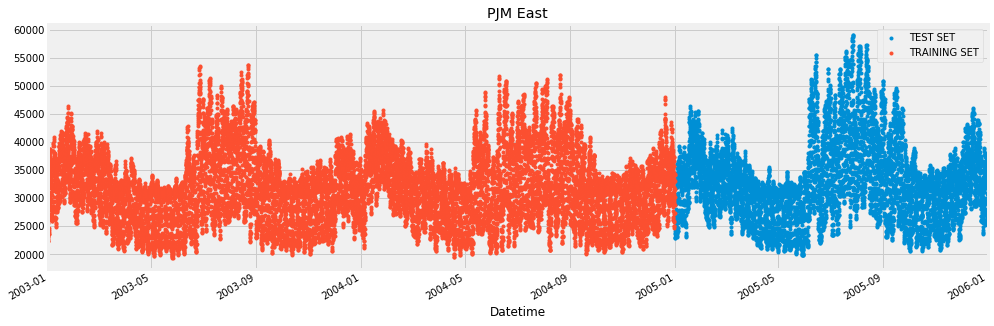

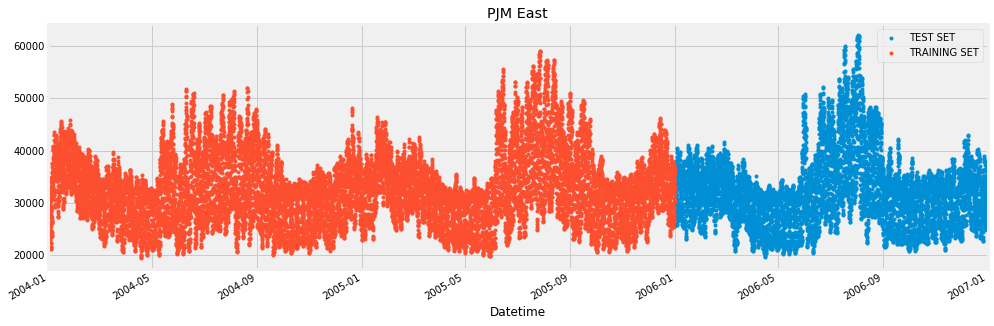

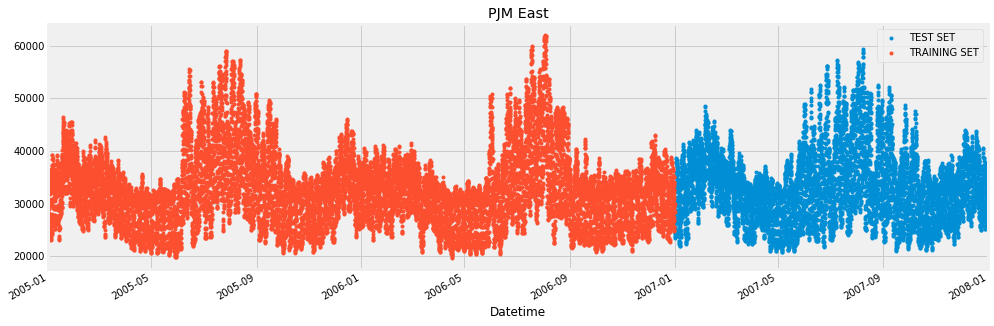

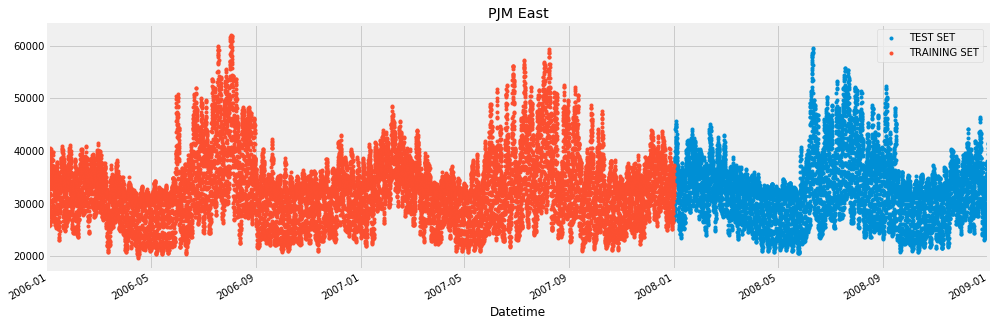

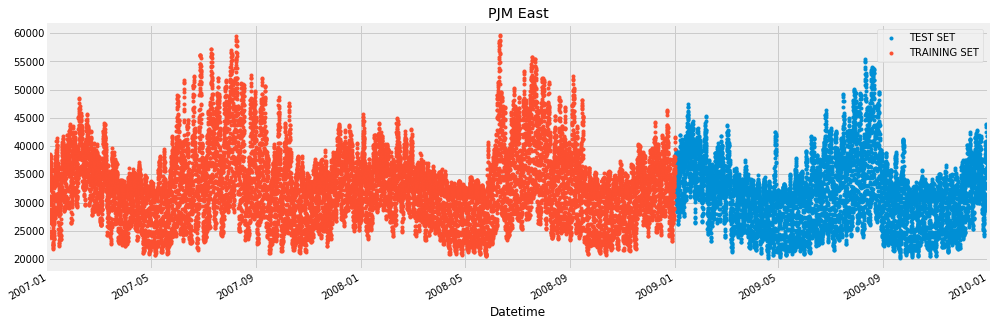

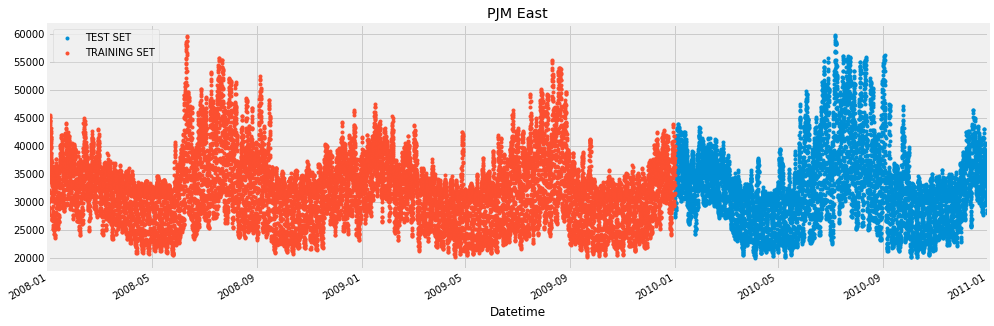

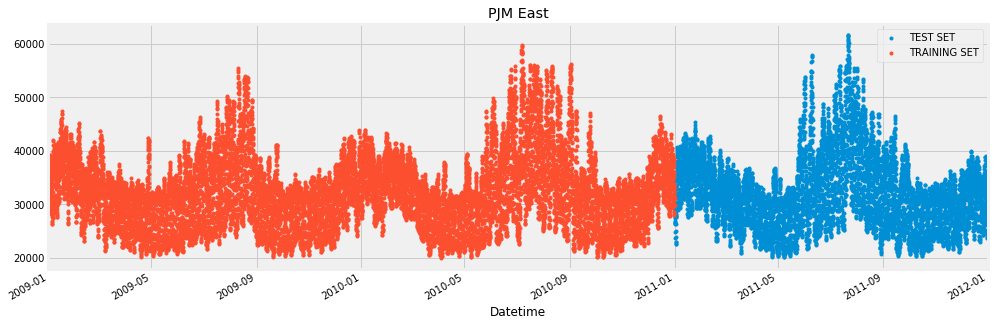

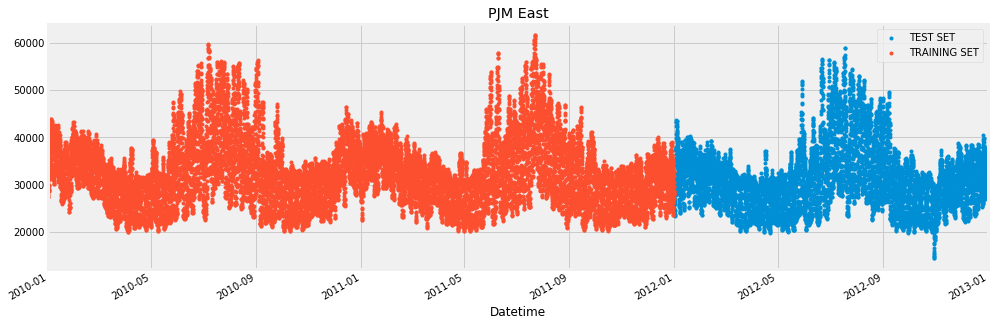

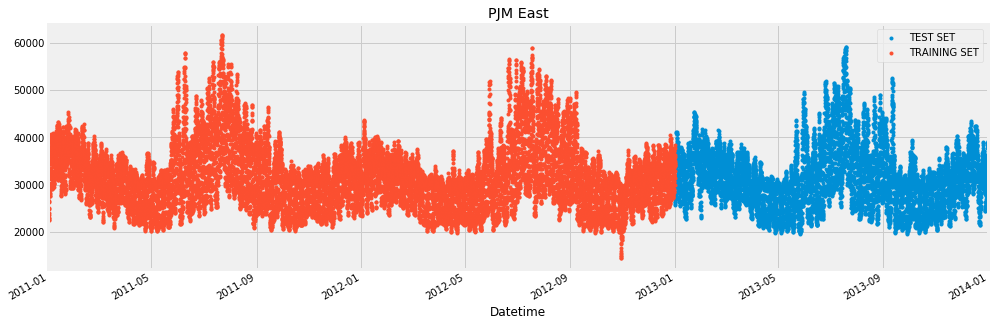

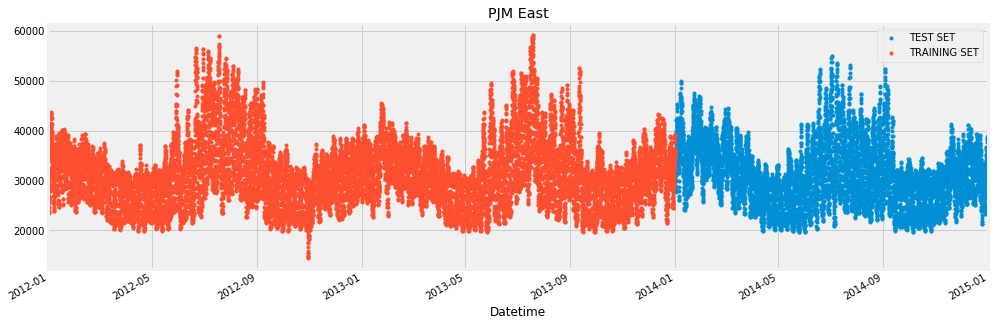

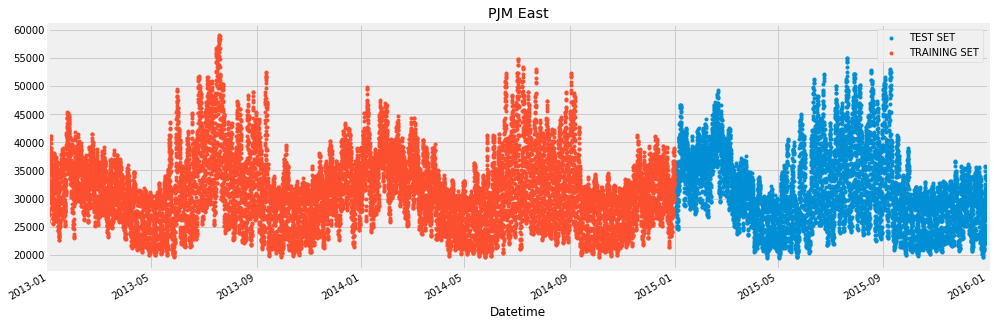

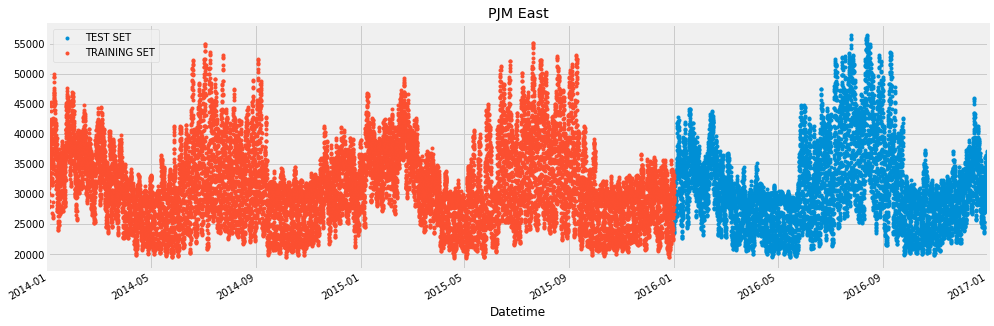

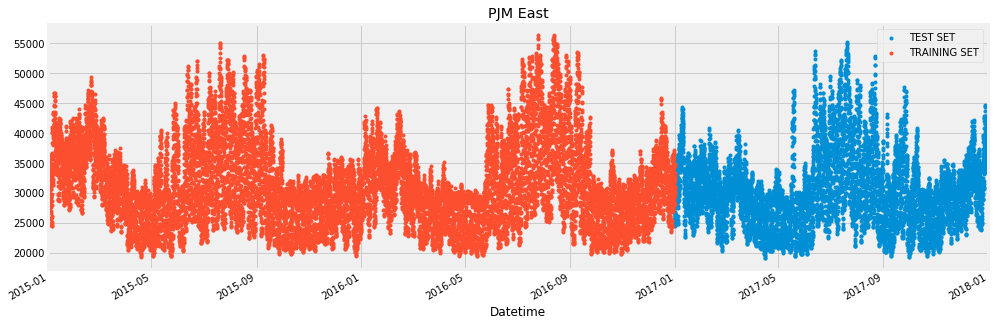

In [7]:
for i in range(0, len(split_dates)):
    print('start date: ', start_dates[i])
    print('split date: ', split_dates[i])
    print('end date: ', end_dates[i], '\n')
    temp_pjme_train = pjme.loc[pjme.index <= split_dates[i]].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_dates[i]].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_dates[i]].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_dates[i]].copy()
    
    temp_plot = nested_pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(nested_pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [12]:
def nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count):
    # Because the data is a time-series, k-fold cross-validation is not sufficient.
    # Instead, we will use nested cross-validation
    
    rmse = [] # Root Mean Squared Error
    mape = [] # Mean Average Percentile Error
    dw = [] # Durbin Watson Statistic
    
    for i in range(0, len(split_dates)):
        temp_start_date = start_dates[i]
        temp_split_date = split_dates[i]
        temp_end_date = end_dates[i]
        
        print('start date: ', temp_start_date)
        print('split date: ', temp_split_date)
        print('end date: ', temp_end_date, '\n')
        
        nested_pjme_train, nested_pjme_test = get_nested_train_test(temp_start_date, temp_split_date, temp_end_date, pjme)
        
        X_train, y_train = create_features(nested_pjme_train, lag_count, label='PJME_MW')
        X_test, y_test = create_features(nested_pjme_test, lag_count, label='PJME_MW')
        print("X Train Length: ", len(X_train))
        print("X Test Length: ", len(X_test))
        
        nested_pjme_test = nested_pjme_test[lag_count:]
    
        reg = train_model(X_train, y_train, X_test, y_test)
        
        nested_pjme_test['MW_Prediction'] = reg.predict(X_test)
        
        nested_pjme_test['error'] = nested_pjme_test['MW_Prediction'] - nested_pjme_test['PJME_MW']
        dw_stat = durbin_watson(nested_pjme_test['error'])
        
        # Evaluate
        print("MSE: ", mean_squared_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction']))
        print("RMSE: ", math.sqrt(mean_squared_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction'])))
        print("MAE: ", mean_absolute_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction']))
        print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(nested_pjme_test['PJME_MW'], nested_pjme_test['MW_Prediction']), 4)))
        print("Durbin-Watson: ", dw_stat)
        print("\n")
        print("================")
        
        rmse.append(math.sqrt(mean_squared_error(y_true=nested_pjme_test['PJME_MW'], y_pred=nested_pjme_test['MW_Prediction'])))
        mape.append(round(mean_absolute_percentage_error(nested_pjme_test['PJME_MW'], nested_pjme_test['MW_Prediction']), 4))
        dw.append(dw_stat) 
    
    return rmse, mape, dw

In [13]:
def get_nested_train_test(start_date, split_date, end_date, pjme):
    temp_pjme_train = pjme.loc[pjme.index <= split_date].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_date].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_date].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_date].copy()
    
    return nested_pjme_train, nested_pjme_test

In [14]:
def train_model(X_train, y_train, X_test, y_test):
    start = datetime.datetime.now()
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    end = datetime.datetime.now()
    print("Total runtime for XGBoost: ", end-start)
    
    return reg

In [32]:
def print_summary_stats(rmse_list, mape_list, dw_list):
    
    lists = [rmse_list, mape_list, dw_list]
    for list_name in lists:
        print("Mean: ", np.mean(list_name))
        print("Max: ", np.max(list_name))
        print("Min: ", np.min(list_name))
        print("SD: ", np.std(list_name), '\n')

### Two Year Nested CV

In [15]:
lag_count = 2
rmse_list, mape_list, dw_list = nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count)
print_summary_stats(rmse_list, mape_list, dw_list)

start date:  01-JAN-2002
split date:  01-JAN-2004
end date:  01-JAN-2005 

X Train Length:  17514
X Test Length:  8781
[11:20:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:42.024630
MSE:  447017.95722266345
RMSE:  668.5940152459215
MAE:  403.0281471536556
Mean Absolute Percentage Error: 1.2836%
Durbin-Watson:  1.6870248402277084


start date:  01-JAN-2003
split date:  01-JAN-2005
end date:  01-JAN-2006 

X Train Length:  17539
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:21:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:40.207412
MSE:  700011.4583774653
RMSE:  836.6668741963347
MAE:  467.0494941100691
Mean Absolute Percentage Error: 1.388%
Durbin-Watson:  1.4222321860568907


start date:  01-JAN-2004
split date:  01-JAN-2006
end date:  01-JAN-2007 

X Train Length:  17539
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:22:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:33.888351
MSE:  464202.70076925866
RMSE:  681.3242258787359
MAE:  431.27820154590614
Mean Absolute Percentage Error: 1.3512%
Durbin-Watson:  1.507896572148953


start date:  01-JAN-2005
split date:  01-JAN-2007
end date:  01-JAN-2008 

X Train Length:  17515
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:22:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:04.090677
MSE:  526105.5732341264
RMSE:  725.3313540955792
MAE:  421.116931677872
Mean Absolute Percentage Error: 1.2858%
Durbin-Watson:  1.7457456684026835


start date:  01-JAN-2006
split date:  01-JAN-2008
end date:  01-JAN-2009 

X Train Length:  17515
X Test Length:  8781


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:23:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:25.925689
MSE:  461623.5809054364
RMSE:  679.428863756491
MAE:  431.0639802467686
Mean Absolute Percentage Error: 1.337%
Durbin-Watson:  1.6257806539402209


start date:  01-JAN-2007
split date:  01-JAN-2009
end date:  01-JAN-2010 

X Train Length:  17539
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:23.944988
MSE:  452957.4630961255
RMSE:  673.0211460987875
MAE:  434.20526971280117
Mean Absolute Percentage Error: 1.405%
Durbin-Watson:  1.5808919780429906


start date:  01-JAN-2008
split date:  01-JAN-2010
end date:  01-JAN-2011 

X Train Length:  17539
X Test Length:  8756


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:24:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:07.600854
MSE:  544834.0184172159
RMSE:  738.1287275382363
MAE:  408.0333800126342
Mean Absolute Percentage Error: 1.2548%
Durbin-Watson:  1.7517277347620333


start date:  01-JAN-2009
split date:  01-JAN-2011
end date:  01-JAN-2012 

X Train Length:  17514
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:01:00.150093
MSE:  437109.8818453943
RMSE:  661.142860390547
MAE:  387.78469032809465
Mean Absolute Percentage Error: 1.2297%
Durbin-Watson:  1.6994568458988577


start date:  01-JAN-2010
split date:  01-JAN-2012
end date:  01-JAN-2013 

X Train Length:  17514
X Test Length:  8781
[11:26:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:55.837600
MSE:  489766.4630015449
RMSE:  699.8331679775865
MAE:  415.7145912961935
Mean Absolute Percentage Error: 1.4021%
Durbin-Watson:  1.5007115141030043


start date:  01-JAN-2011
split date:  01-JAN-2013
end date:  01-JAN-2014 

X Train Length:  17539
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:42.454399
MSE:  489523.26755104575
RMSE:  699.6593939561204
MAE:  416.715723626456
Mean Absolute Percentage Error: 1.3511%
Durbin-Watson:  1.6438039649443559


start date:  01-JAN-2012
split date:  01-JAN-2014
end date:  01-JAN-2015 

X Train Length:  17539
X Test Length:  8759


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:30.980093
MSE:  548748.1889272573
RMSE:  740.7753970855521
MAE:  426.85263171273834
Mean Absolute Percentage Error: 1.3726%
Durbin-Watson:  1.6555496932303642


start date:  01-JAN-2013
split date:  01-JAN-2015
end date:  01-JAN-2016 

X Train Length:  17517
X Test Length:  8759


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:28:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:56.121869
MSE:  489946.88535926666
RMSE:  699.9620599427277
MAE:  397.6864301183069
Mean Absolute Percentage Error: 1.292%
Durbin-Watson:  1.6797999367901875


start date:  01-JAN-2014
split date:  01-JAN-2016
end date:  01-JAN-2017 

X Train Length:  17519
X Test Length:  8783


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:29:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:28.421926
MSE:  549373.0632497373
RMSE:  741.1970475182272
MAE:  437.5087742745218
Mean Absolute Percentage Error: 1.4318%
Durbin-Watson:  1.548668682098575


start date:  01-JAN-2015
split date:  01-JAN-2017
end date:  01-JAN-2018 

X Train Length:  17543
X Test Length:  8759


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:30:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:48.918118
MSE:  506165.10817022156
RMSE:  711.4528151397122
MAE:  409.5652206391283
Mean Absolute Percentage Error: 1.3678%
Durbin-Watson:  1.678360337552661




### One-Year CV

In [30]:
start_dates = [
    '01-JAN-2002',
    '01-JAN-2003',
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011', 
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016'
]

split_dates = [
    '01-JAN-2003',
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016', 
    '01-JAN-2017' 
]

end_dates = [
    '01-JAN-2004',
    '01-JAN-2005',
    '01-JAN-2006',
    '01-JAN-2007',
    '01-JAN-2008',
    '01-JAN-2009',
    '01-JAN-2010',
    '01-JAN-2011',
    '01-JAN-2012',
    '01-JAN-2013',
    '01-JAN-2014',
    '01-JAN-2015',
    '01-JAN-2016',
    '01-JAN-2017', 
    '01-JAN-2018' 
]

In [31]:
lag_count = 2
rmse_list, mape_list, dw_list = nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count)
print_summary_stats(rmse_list, mape_list, dw_list)

start date:  01-JAN-2002
split date:  01-JAN-2003
end date:  01-JAN-2004 

X Train Length:  8756
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:58:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:22.450990
MSE:  526534.5251002001
RMSE:  725.6269875770885
MAE:  471.19573359169806
Mean Absolute Percentage Error: 1.5164%
Durbin-Watson:  1.3959403022150103


start date:  01-JAN-2003
split date:  01-JAN-2004
end date:  01-JAN-2005 

X Train Length:  8757
X Test Length:  8781


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:58:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:24.340937
MSE:  497002.2378839159
RMSE:  704.9838564704272
MAE:  438.08535296378545
Mean Absolute Percentage Error: 1.3898%
Durbin-Watson:  1.5880858636977042


start date:  01-JAN-2004
split date:  01-JAN-2005
end date:  01-JAN-2006 

X Train Length:  8781
X Test Length:  8757
[11:59:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:15.324048
MSE:  976620.6793617405
RMSE:  988.2412050515504
MAE:  560.2893475398253
Mean Absolute Percentage Error: 1.6457%
Durbin-Watson:  1.1875072447520238


start date:  01-JAN-2005
split date:  01-JAN-2006
end date:  01-JAN-2007 

X Train Length:  8757
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:59:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:09.888506
MSE:  533334.3691154394
RMSE:  730.2974524914073
MAE:  473.42626479173805
Mean Absolute Percentage Error: 1.471%
Durbin-Watson:  1.5077761395570262


start date:  01-JAN-2006
split date:  01-JAN-2007
end date:  01-JAN-2008 

X Train Length:  8757
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:59:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:29.996760
MSE:  626932.6410612006
RMSE:  791.7907811165779
MAE:  489.65808201652965
Mean Absolute Percentage Error: 1.4822%
Durbin-Watson:  1.5432832791832964


start date:  01-JAN-2007
split date:  01-JAN-2008
end date:  01-JAN-2009 

X Train Length:  8757
X Test Length:  8781
[11:59:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:10.590712
MSE:  533107.6722829824
RMSE:  730.142227434479
MAE:  482.8939509398844
Mean Absolute Percentage Error: 1.5021%
Durbin-Watson:  1.532548736699714


start date:  01-JAN-2008
split date:  01-JAN-2009
end date:  01-JAN-2010 

X Train Length:  8781
X Test Length:  8757
[12:00:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:08.600991
MSE:  517088.6141660855
RMSE:  719.0887387284587
MAE:  484.3057143570858
Mean Absolute Percentage Error: 1.5562%
Durbin-Watson:  1.4633402324941525


start date:  01-JAN-2009
split date:  01-JAN-2010
end date:  01-JAN-2011 

X Train Length:  8757
X Test Length:  8756
[12:00:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:14.590969
MSE:  675527.6917654837
RMSE:  821.9049164991554
MAE:  493.98654873265474
Mean Absolute Percentage Error: 1.4972%
Durbin-Watson:  1.508579384846902


start date:  01-JAN-2010
split date:  01-JAN-2011
end date:  01-JAN-2012 

X Train Length:  8756
X Test Length:  8757


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:00:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:28.730097
MSE:  496963.0803328742
RMSE:  704.9560839746503
MAE:  436.35106624521814
Mean Absolute Percentage Error: 1.3825%
Durbin-Watson:  1.6021032896407719


start date:  01-JAN-2011
split date:  01-JAN-2012
end date:  01-JAN-2013 

X Train Length:  8757
X Test Length:  8781


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:01:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:25.804965
MSE:  541647.418191108
RMSE:  735.966995313722
MAE:  454.9720812781147
Mean Absolute Percentage Error: 1.5222%
Durbin-Watson:  1.4139696968125062


start date:  01-JAN-2012
split date:  01-JAN-2013
end date:  01-JAN-2014 

X Train Length:  8781
X Test Length:  8757
[12:01:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:10.680887
MSE:  613784.6280426072
RMSE:  783.4440809927708
MAE:  493.27559113423547
Mean Absolute Percentage Error: 1.5876%
Durbin-Watson:  1.5392295550805257


start date:  01-JAN-2013
split date:  01-JAN-2014
end date:  01-JAN-2015 

X Train Length:  8757
X Test Length:  8759


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:01:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:14.454581
MSE:  554521.195071955
RMSE:  744.661799122229
MAE:  436.91071728008336
Mean Absolute Percentage Error: 1.4041%
Durbin-Watson:  1.6645136708705395


start date:  01-JAN-2014
split date:  01-JAN-2015
end date:  01-JAN-2016 

X Train Length:  8759
X Test Length:  8759
[12:01:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Total runtime for XGBoost:  0:00:17.027455
MSE:  545912.9830080876
RMSE:  738.8592443815585
MAE:  455.00707709570156
Mean Absolute Percentage Error: 1.4684%
Durbin-Watson:  1.5563935476073842


start date:  01-JAN-2015
split date:  01-JAN-2016
end date:  01-JAN-2017 

X Train Length:  8759
X Test Length:  8783


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:02:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:10.233588
MSE:  622822.4764983425
RMSE:  789.191026620515
MAE:  496.79803869157746
Mean Absolute Percentage Error: 1.6278%
Durbin-Watson:  1.4765368124166345


start date:  01-JAN-2016
split date:  01-JAN-2017
end date:  01-JAN-2018 

X Train Length:  8783
X Test Length:  8759


C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Richard\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:02:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total runtime for XGBoost:  0:00:13.548757
MSE:  550464.9289692085
RMSE:  741.9332375417673
MAE:  449.70360597849356
Mean Absolute Percentage Error: 1.497%
Durbin-Watson:  1.5778622155743176


[725.6269875770885, 704.9838564704272, 988.2412050515504, 730.2974524914073, 791.7907811165779, 730.142227434479, 719.0887387284587, 821.9049164991554, 704.9560839746503, 735.966995313722, 783.4440809927708, 744.661799122229, 738.8592443815585, 789.191026620515, 741.9332375417673]
Mean:  763.405908887757
Max:  988.2412050515504
Min:  704.9560839746503
SD:  68.52562293531393 

[1.5164, 1.3898, 1.6457, 1.471, 1.4822, 1.5021, 1.5562, 1.4972, 1.3825, 1.5222, 1.5876, 1.4041, 1.4684, 1.6278, 1.497]
Mean:  1.5033466666666666
Max:  1.6457
Min:  1.3825
SD:  0.07585603791979177 

[1.3959403022150103, 1.5880858636977042, 1.1875072447520238, 1.507

### Conclusion

Below are the scores for each set of time intervals: five years, two years, and one year.

Forecasting accuracy diminishes from 1.23% to to 1.334% to 1.5% as the training period is decresead from five years to two years, and then from two years to one year.

This pattern extends into the durbin-watson statistic, where the average DW stat is reduced by about ten basis points for each step. This implies that the more training data we have, the more generalizable a trained model will be.

### Five-Year and Overall Scores

#### RMSE
* Overall: 693.56
* Maximum: 709.46
* Minimum: 621.75

#### Mean Absolute Percentage Error
* Overall: 1.23%
* Maximum: 1.31%
* Minimum: 1.12%

Additionally, the **DW Statistic** for the overall model is near two at 1.73, suggesting little autocorrelation of residuals.

### Two-Year Scores

#### RMSE
* Average: 711.17
* Maximum: 836.66
* Minimum: 661.14
* Standard Dev: 43.51

#### Mean Absolute Percentage Error
* Average: 1.3395
* Maximum: 1.4318
* Minimum: 1.2297
* Standard Dev: 0.059

#### DW Staistic
* Average: 1.62
* Maximum: 1.75
* Minimum: 1.42
* Standard Dev: 0.094

### One-Year Scores

#### RMSE
* Average: 763.40
* Maximum: 988.24
* Minimum: 704.95

#### Mean Absolute Percentage Error
* Average: 1.503
* Maximum: 1.6457
* Minimum: 1.3825

#### DW Staistic
* Average: 1.50
* Maximum: 1.664
* Minimum: 1.187
* Standard Dev: 0.109